Single-qubit gate errors consisting of a single qubit depolarizing error followed by a single qubit thermal relaxation error.

Two-qubit gate errors consisting of a two-qubit depolarizing error followed by single-qubit thermal relaxation errors on both qubits in the gate.

Single-qubit readout errors on the classical bit value obtained from measurements on individual qubits.

For the gate errors the error parameter of the thermal relaxation errors is derived using the thermal_relaxation_error function from aer.noise.errors module, along with the individual qubit 
 and 
 parameters, and the gate_time parameter from the device backend properties. The probability of the depolarizing error is then set so that the combined average gate infidelity from the depolarizing error followed by the thermal relaxation is equal to the gate_error value from the backend properties.

For the readout errors the probability that the recorded classical bit value will be flipped from the true outcome after a measurement is given by the qubit readout_errors.

In [1]:
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ

import numpy as np


# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [2]:
from qiskit.providers.fake_provider import FakeVigo
device_backend = FakeVigo()
# will use ibm_brisbane as backend

properties = device_backend.properties()
temp = 0
noise_model= NoiseModel.from_backend_properties(
        backend_properties=properties,
        gate_error=True,
        readout_error=True,
        thermal_relaxation=True,
        temperature=0,
        gate_lengths=None,
        gate_length_units="ns",
        dt=None,
    )
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['id', 'sx', 'x', 'measure', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [5]:
# Construct quantum circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

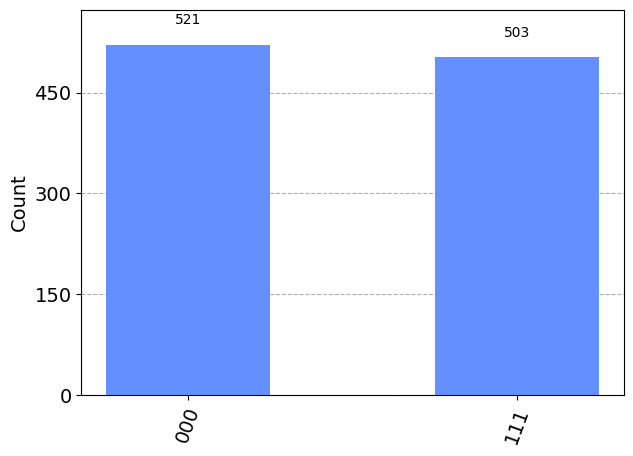

In [6]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

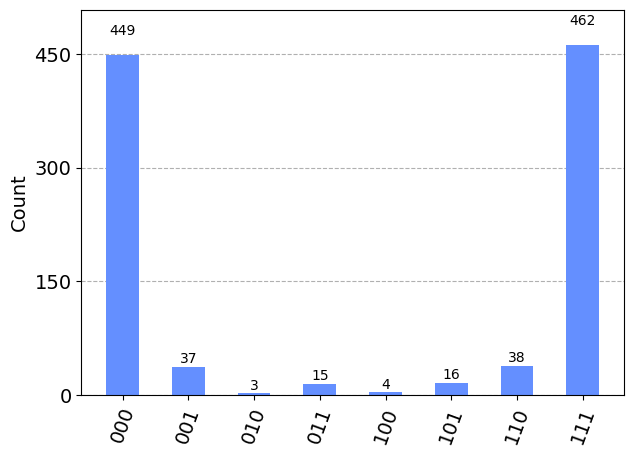

In [7]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_model)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

In [8]:
import qiskit
from mitiq import pec
from mitiq import zne
from mitiq.rem import generate_tensored_inverse_confusion_matrix
from typing import Any, Sequence
from qiskit.result import LocalReadoutMitigator
from mitiq.pec.representations.depolarizing import represent_operation_with_local_depolarizing_noise,represent_operation_with_global_depolarizing_noise
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise


error_list = [['h',0,0],['cx',0,0,1],['cx',0,1,2]]

def rep_for_simulator(error_list):
    '''
    error_list = [[gate_name:str,error:float,qubit1,qubit2]]
    '''
    rep = []
    for i in error_list:
        c = qiskit.QuantumCircuit(3)
        if len(i)==3:
            if i[0]=='h':
                c.h(i[2])
            elif i[0]=='rz':
                c.rz(i[2])
            depolarizing_rep = represent_operation_with_local_depolarizing_noise(
                ideal_operation=c,
                noise_level=i[1]/2,
            )
            
        elif len(i)==4:
            c.cx(i[2],i[3])
            depolarizing_rep = represent_operation_with_global_depolarizing_noise(
                ideal_operation=c,
                noise_level=i[1]/2,
            )
        rep += [depolarizing_rep]
    return rep

rep_for_PEC = rep_for_simulator(error_list)

class AfterErrorMitigation:
    def __init__(self, circuit: QuantumCircuit):
        self.circuit = circuit
        self.qubits: list = circuit.qubits
        self.num_qubits = len(self.qubits)
        self.simulator = sim_noise
        
    def noisy_executor_after_rem(self, circuit, shots: int = 1024):
        """Returns the expectation value to be mitigated.
            Args:
            circuit: Circuit to run.
            shots: Number of times to execute the circuit to compute the expectation value.
        """
    
        # Simulate the circuit with noise
    
        job = qiskit.execute(
            experiments=circuit,
            backend=sim_noise,
            optimization_level=0,  # Important to preserve folded gates.
            shots=shots,
        )
        
        # build local readout error mitigator
        A_list=[]
        '''
        To do: add value to p1 and p0 for each qubits
        '''
        for i in self.qubits:
            p1 = 0 # list_of_readouterror[i] # P(0|1)
            p0 = 0 # P(1|0)
            A_i = np.array([[1.0 - p0, p1],
                            [p0, 1.0 - p1]])
            A_list += [A_i]
        mitigator = LocalReadoutMitigator(A_list)
        
        # Convert from raw measurement counts to the expectation value
        counts = job.result().get_counts()  
        mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
        
        # the probability of state 001, the ideal value is 0
        prob_001 = mitigated_quasi_probs.get(1)
        return prob_001
   
    def combine_PEC(self):
        rep = rep_for_PEC 
        mitigated = pec.execute_with_pec(self.circuit, self.noisy_executor_after_rem, representations=rep)
        return mitigated
    
    def combine_ZNE(self):
        linear_factory = zne.inference.LinearFactory(scale_factors=[1.0, 3.0, 5.0])
        mitigated = zne.execute_with_zne(self.circuit, self.noisy_executor_after_rem, factory=linear_factory)
        return mitigated
        
    def run(self, zne:bool = True, pec:bool = False):
        """returns the mitigated value after REM, with ZNE or PEC
        
        """
        if zne and pec:
            # return self.combine_PEC()
            print('can not mitigate with both zne and pec, otherwise the cost would be too much')
        elif zne:
            return self.combine_ZNE()
        elif pec:
            print('due to mitiq bug, pec is not avaliable for now, will update later')
        else:
            return self.noisy_executor_after_rem()
        

In [9]:
# return the probability to get state 001
# which the ideal probability is 0
AFE = AfterErrorMitigation(circ)
AFE.run()

0.027262369791666657